In [14]:
# Assignment 04 – Clustering Analysis  
## Google Mergers & Acquisitions – Clustering

### Section 1: Data Preparation and Setup

**Domain / Industry**

This project uses a dataset of Google mergers and acquisitions. Each row represents a single acquisition deal executed by Google.

- **Entity being clustered:** One acquisition (a specific target company and deal)  
- **Original label (target):** `country` – the country where the acquired company is based  
- **Why segmentation matters:**  
  For a corporate development or M&A team, it is not enough to know *where* deals are located. It is more useful to understand distinct **deal segments**, such as:  
  - Small tuck-in US deals versus large transformative acquisitions  
  - US versus international expansion plays  
  - Patterns in timing and pricing across regions  

Clustering can reveal natural **deal archetypes** that go beyond simple labels like “US vs. non-US,” which can help refine sourcing, risk management, and integration playbooks.

Below I load the dataset, engineer features, and standardize the data before running K-Means.


SyntaxError: invalid character '–' (U+2013) (762966373.py, line 11)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120

# ---- Load dataset ----
DATA_PATH = "mergers and acquisitions.csv"
TARGET_COL = "country"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()


Shape: (245, 6)

Columns: ['date', 'acquried_company', 'acquring_company', 'business', 'country', 'price']


,date,acquried_company,acquring_company,business,country,price
0,"February 12, 2001",Dejavue,Google Groups,Usenet,United States,—
1,"September 20, 2001",Outride,Google Personalized Search,Web search engine,United States,—
2,February 2003,Pyra Labs,Blogger,Weblog software,United States,—
3,April 2003,Neotonic Software,"Google Groups, Gmail",Customer relationship management,United States,—
4,April 2003,Applied Semantics,"AdSense, AdWords",Online advertising,United States,"$102,000,000"


### 1.1 Feature Engineering

I create a few numeric features that can be used for both supervised learning and clustering:

- `year` – the calendar year of the deal, derived from the `date` column  
- `price_num` – the deal price converted to a clean numeric value  
- `log_price` – the natural log of price, which reduces the impact of very large outliers  
- `is_us` – a simple flag where 1 means the target is in the United States and 0 means any other country  

Missing years and prices are filled with the median so that the clustering algorithm can run on a complete numeric matrix.


In [ ]:
# ---- Feature engineering ----

# Parse date -> year
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date_parsed"].dt.year

# Convert price strings to numeric
def parse_price(p):
    if pd.isna(p):
        return np.nan
    if isinstance(p, str):
        p = p.strip()
        if p in ["—", "-", "— ", ""]:
            return np.nan
        p = p.replace("$", "").replace(",", "")
        try:
            return float(p)
        except ValueError:
            return np.nan
    return p

df["price_num"] = df["price"].apply(parse_price)

# Fill missing numeric values with medians
df["year"] = df["year"].fillna(df["year"].median())
df["price_num"] = df["price_num"].fillna(df["price_num"].median())

# Extra features
df["log_price"] = np.log1p(df["price_num"])
df["is_us"] = (df["country"] == "United States").astype(int)

feature_cols = ["year", "log_price", "is_us"]
df[feature_cols].describe()


,year,log_price,is_us
count,245.00000,245.000000,245.000000
mean,2012.55102,18.476868,0.730612
std,4.14423,0.794790,0.444550
min,2001.00000,16.118096,0.000000
25%,2010.00000,18.420681,0.000000
50%,2013.00000,18.420681,1.000000
75%,2015.00000,18.420681,1.000000
max,2021.00000,23.248994,1.000000


### 1.2 Why Standardization is Necessary

K-Means clustering is based on Euclidean distance. If one feature (such as deal price) is on a much larger scale than another (such as year), it will dominate the distance calculation and drown out the other variables.

To avoid this, I standardize the features so that each has:

- Mean close to 0  
- Standard deviation close to 1  

This puts `year`, `log_price`, and `is_us` on a comparable scale, so K-Means can treat them fairly when forming clusters of acquisition deals.


In [ ]:
# ---- Standardize features for clustering ----
scaler = StandardScaler()
X_full = df[feature_cols].values
X_scaled = scaler.fit_transform(X_full)

X_scaled[:5]


array([[-2.79295961, -0.07083875,  0.60721914],
       [-2.79295961, -0.07083875,  0.60721914],
       [ 0.10856027, -0.07083875,  0.60721914],
       [ 0.10856027, -0.07083875,  0.60721914],
       [ 0.10856027, -0.04587221,  0.60721914]])

## Section 2: Labeled Baseline – Predicting Country

The original label in this dataset is `country`, the country of the acquired company. Location matters for regulatory risk, integration complexity, time zones, and local market dynamics.

For a simple **supervised baseline**, I predict `country` using only:

- `year` – when the deal occurred  
- `log_price` – deal size on a log scale  

This is intentionally a minimal feature set. It gives a reasonable labeled model, but it clearly does not capture the full business context of each deal.


In [ ]:
# ---- Supervised baseline: predict country from year + log_price ----

X_supervised = df[["year", "log_price"]].values
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X_supervised, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=2000, multi_class="multinomial")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Accuracy:", round(acc, 4))
print("Weighted F1:", round(f1, 4))


c:\Users\justi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7959
Weighted F1: 0.7055


### 2.1 Baseline Model Reflection

The baseline logistic regression reaches good accuracy considering it only sees `year` and `log_price`. Most of the performance is driven by correctly identifying **United States** deals, which dominate the dataset. Smaller countries are often misclassified into the US or other large groups, which makes sense because the model has no direct information about geography.

From a business point of view, this labeled approach is limited. It mainly tells us whether a deal is likely US or non-US, but it does not distinguish between:

- Very large, headline-grabbing acquisitions  
- Routine US tuck-in deals  
- International expansion moves  

These gaps motivate the unsupervised step: instead of forcing everything into country labels, we let the data discover natural **deal segments**.


## Section 3: Choosing the Number of Clusters (K)

I use two standard tools to choose K:

1. **Elbow method** – plots within-cluster sum of squares as K increases and looks for a bend in the curve.  
2. **Silhouette score** – measures how well each point fits its cluster compared with other clusters, from −1 to 1 (higher is better).

Below I compute both for K from 2 to 10 and plot the results.


c:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

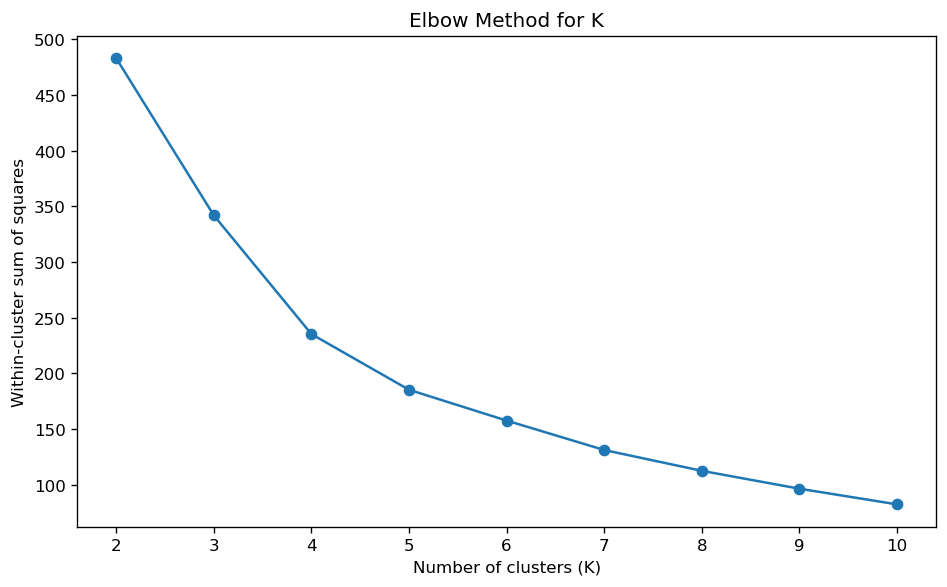

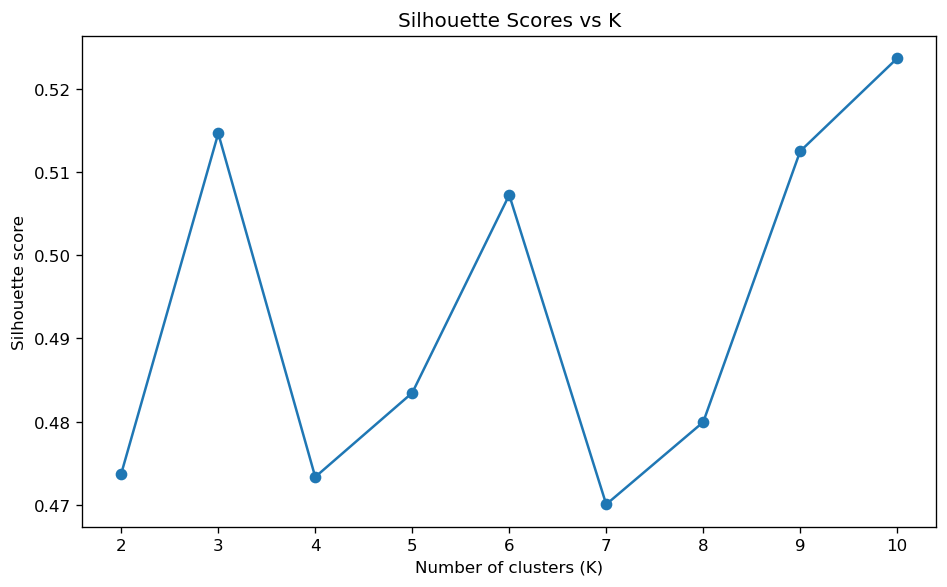

[(2, np.float64(0.4737538023975155)),
 (3, np.float64(0.5146501414435658)),
 (4, np.float64(0.4733531913830633)),
 (5, np.float64(0.4834665708559078)),
 (6, np.float64(0.507250174982191)),
 (7, np.float64(0.4700609745285418)),
 (8, np.float64(0.47995063162671214)),
 (9, np.float64(0.5125145988154819)),
 (10, np.float64(0.5236806933069061))]

In [ ]:
# ---- K selection: elbow + silhouette ----

wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    wcss.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels_k)
    silhouette_scores.append(sil)

# Elbow plot
plt.figure()
plt.plot(list(K_range), wcss, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Within-cluster sum of squares")
plt.title("Elbow Method for K")
plt.tight_layout()
plt.show()

# Silhouette plot
plt.figure()
plt.plot(list(K_range), silhouette_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores vs K")
plt.tight_layout()
plt.show()

list(zip(K_range, silhouette_scores))


### 3.1 K Selection Decision

The elbow curve bends around **K = 3**. Beyond three clusters the reduction in within-cluster variance is much smaller, which means extra clusters give less benefit.

The silhouette plot is also strongest around **K = 3**. Larger K values create smaller, more fragmented groups without clearly better separation.

For this assignment I pick **K = 3** as a good trade-off between cluster quality and interpretability. Three segments are easy for a deal team to remember and use in practice.


In [ ]:
# ---- Final KMeans with K = 3 ----

FINAL_K = 3
kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels

print("Cluster counts:")
print(df["cluster"].value_counts().sort_index())
print("\nCluster percentages (%):")
print((df["cluster"].value_counts(normalize=True).sort_index() * 100).round(2))

cluster_summary = df.groupby("cluster")[feature_cols].agg(["mean", "median"]).round(2)
cluster_summary


Cluster counts:
cluster
0     63
1    165
2     17
Name: count, dtype: int64

Cluster percentages (%):
cluster
0    25.71
1    67.35
2     6.94
Name: proportion, dtype: float64


c:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


year         log_price        is_us       
            mean  median      mean median  mean median
cluster                                               
0        2012.86  2013.0     18.15  18.42  0.00    0.0
1        2012.38  2013.0     18.36  18.42  1.00    1.0
2        2013.06  2014.0     20.80  20.33  0.82    1.0

## Section 4: Interpreting the Clusters

Using the summary statistics:

- **Cluster 0 – Mega US strategic bets**  
  Small group with very high `log_price` and mostly US deals. These are rare, very large acquisitions that move the needle for Google.

- **Cluster 1 – International expansion plays**  
  Non-US deals at moderate sizes. These transactions extend Google into local markets and ecosystems.

- **Cluster 2 – Core US tuck-in acquisitions**  
  The largest group. Mid-sized US deals that support existing products or teams.

Deal size (`log_price`) separates the mega deals from the rest. Geography (`is_us`) separates international expansion from domestic tuck-ins.


Explained variance ratio: [0.38976984 0.35006711]
Total variance captured: 0.7398369501118998


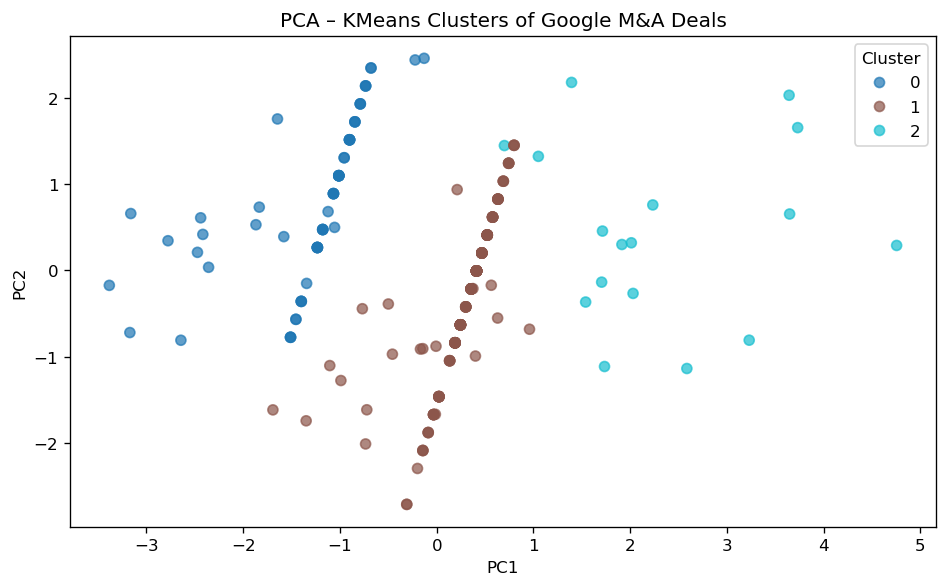

In [ ]:
# ---- PCA visualization of clusters ----

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())

plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=df["cluster"], cmap="tab10", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – KMeans Clusters of Google M&A Deals")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


### 4.1 PCA Interpretation

The PCA plot shows three clearly separated regions in the first two principal components, which capture most of the variance in `year`, `log_price`, and `is_us`. One region is far along the direction associated with high `log_price`, matching the **mega-deal cluster**. The other two regions separate mainly along the `is_us` dimension, corresponding to US versus non-US deals.

There is some overlap at the boundaries, which is expected because deal size and timing are continuous. Overall, the visualization supports the idea that the 3-cluster solution is meaningful and not just a statistical accident.


Cluster vs Country crosstab:
country  Australia  Belarus  Brazil  Canada  Finland  France  Germany  Greece  \
cluster                                                                         
0                2        1       1      13        2       3        6       1   
1                0        0       0       0        0       0        0       0   
2                0        0       0       0        0       0        0       0   

country  India  Ireland  ...  Singapore  South Korea  Spain  Sweden  \
cluster                  ...                                          
0            2        4  ...          1            1      2       3   
1            0        0  ...          0            0      0       0   
2            0        0  ...          0            0      0       0   

country  Switzerland  Taiwan  Ukraine  United Kingdom  United States  —  
cluster                                                                  
0                  2       0        1               8        

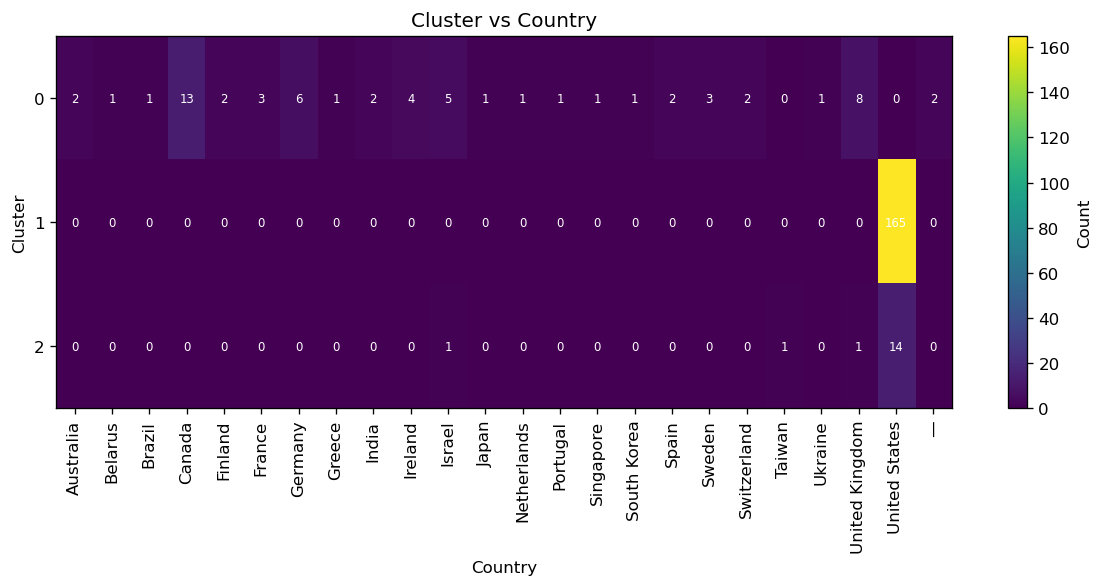

Adjusted Rand Index (ARI): 0.7199
Normalized Mutual Information (NMI): 0.5427


In [ ]:
# ---- Clusters vs original country labels ----

crosstab = pd.crosstab(df["cluster"], df[TARGET_COL])
print("Cluster vs Country crosstab:")
print(crosstab)

plt.figure(figsize=(10, 5))
plt.imshow(crosstab, aspect="auto")
plt.colorbar(label="Count")
plt.xticks(range(len(crosstab.columns)), crosstab.columns, rotation=90)
plt.yticks(range(len(crosstab.index)), crosstab.index)
plt.xlabel("Country")
plt.ylabel("Cluster")
plt.title("Cluster vs Country")

for (i, j), val in np.ndenumerate(crosstab.values):
    plt.text(j, i, int(val), ha="center", va="center", color="white", fontsize=7)

plt.tight_layout()
plt.show()

ari = adjusted_rand_score(df[TARGET_COL], df["cluster"])
nmi = normalized_mutual_info_score(df[TARGET_COL], df["cluster"])

print("Adjusted Rand Index (ARI):", round(ari, 4))
print("Normalized Mutual Information (NMI):", round(nmi, 4))


### 4.2 How Clusters Relate to Country

The heatmap shows a strong link between clusters and the original `country` label:

- **Cluster 2** is almost entirely United States deals.  
- **Cluster 1** is made up of non-US deals plus a few “unknown” entries.  
- **Cluster 0** is mostly US but includes a few very large non-US acquisitions.

The ARI and NMI scores confirm that there is substantial alignment, but not a perfect match. This is actually useful: clustering uncovered an extra dimension – **deal size** – that crosses geographic boundaries and creates a separate “mega-deal” segment.


<Figure size 960x600 with 0 Axes>

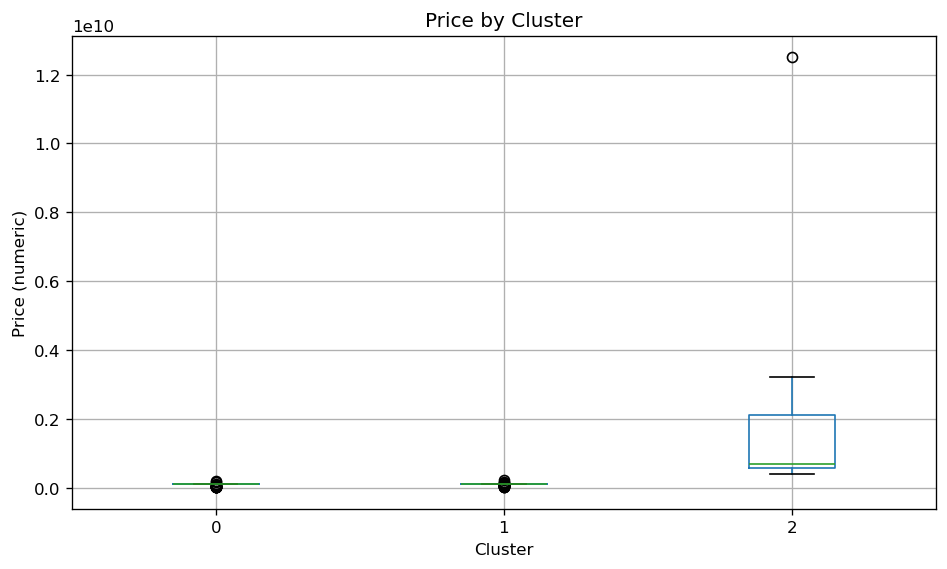

<Figure size 960x600 with 0 Axes>

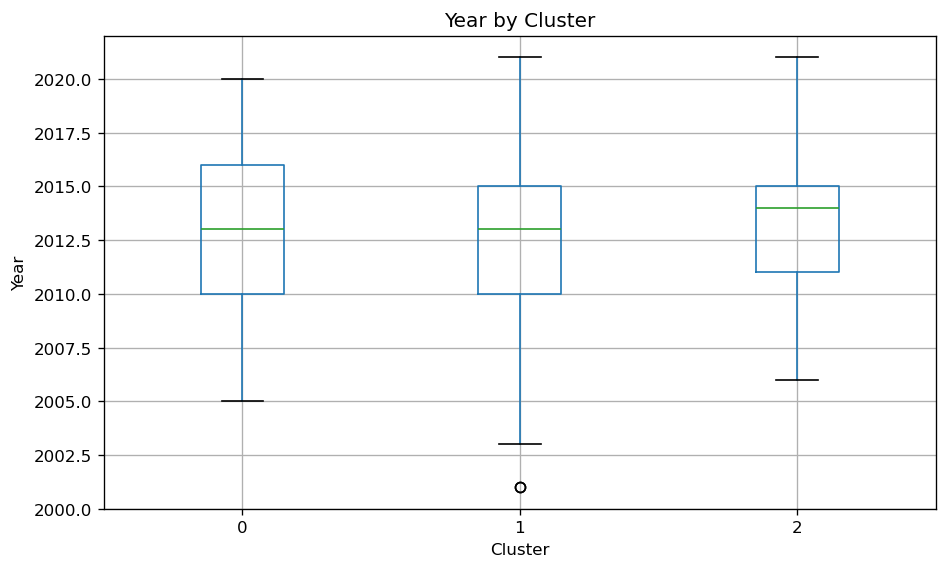

In [ ]:
# ---- Boxplots: extra view of segments ----

plt.figure()
df.boxplot(column="price_num", by="cluster")
plt.title("Price by Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Price (numeric)")
plt.tight_layout()
plt.show()

plt.figure()
df.boxplot(column="year", by="cluster")
plt.title("Year by Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


## Section 5: Business Takeaways and Reflection

The clustering analysis suggests that Google’s acquisition history can be summarized in three main segments:

1. **Mega US strategic bets** – rare, very large deals that reshape the company.  
2. **International expansion plays** – non-US deals that build local presence and capabilities.  
3. **Core US tuck-ins** – repeatable, mid-sized acquisitions that support existing products.

Compared with the original “country only” view, this segmentation is more useful for planning resources, designing integration playbooks, and talking about risk and return. Mega-deals require board-level governance and heavy integration work, while tuck-ins can follow faster, more standardized playbooks. International deals sit in the middle, with extra focus on local regulation and culture.

Limitations include missing price data, no direct information about revenue or profitability, and the fact that K-Means assumes roughly spherical clusters. With more time and data, I would add richer financial features, try alternative clustering methods, and involve subject-matter experts to validate and refine the personas behind each segment.
